# The Cumulative Density Function and Inverse Cumulative Density Function of the Hoyt Distribution 

The Hoyt Distribution (also known as the Nakagami-q Distribution) is a Probability Density Function which models the norm of a 2D random variable where each component follows a normal distribution.
The probability density function of the components both have mean equal to zero, but do not necessarily have equal variances.

Let 

$$x\sim{\mathcal N}(0, \sigma_x^2)$$

and

$$y\sim{\mathcal N}(0, \sigma_y^2)$$

be two random variables that follow Gaussian distributions.

Furthermore, let

$$r = \sqrt{x^2 + y^2}$$

Then $r$ follows a Hoyt distribution.

Note that when the two standard deviations are equal, i.e. $\sigma_x = \sigma_y = \sigma$ then $r$ follows a Rayleigh distribution with shape parameter $\sigma$.
Furthermore, $x$ and $y$ can be correlated, with a 2D variance-covariance matrix denoted by $P$.
Since $r$ is invariant to rotations, one can diagonalize $P$ and use the eigenvalues of this matrix as $\sigma_x^2$ and $\sigma_y^2$.

The cumulative density function (CDF) of the Hoyt distribution does not have a closed-form solution.
The CDF is useful for calculating tail probabilities, i.e. 

$${\rm prob}(|x| \leq t) = {\rm CDF}(t)$$

or

$${\rm prob}(|x| \geq t) = 1 - {\rm CDF}(t)$$

Given a tail probability value (also known as "probability of exceedance") $p$, a threshold $t$ can be calculated using the inverse CDF.

Since the CDF of a Hoyt distribution does not admit a closed-form solution, calculating its inverse adds another layer of complexity when attempting to calculate probability thresholds.

In this project, a quadrature-based method for numerically calculating the CDF and its inverse is implemented.
This method offers arbitrary accuracy, i.e. the number of terms in the quadrature can be calculated before hand.
Consequently, the CDF and its inverse can be calculated using elementary functions.

## List of Functions
The following functions are implemented in `hoyt_cumulative_density.py`:
1. `cumulative_density_hoyt`: Calculates the CDF of the Hoyt distribution using the foregoing reference.
2. `cumulative_density_hoyt_series`: Calculates the CDF of the Hoyt distribution using a series solution, used as a check for `cumulative_density_hoyt`.
3. `inverse_tail_probability_hoyt`: Calculates the threshold which guarantees a user-defined probability of exceedance, using an inverse CDF based on a Newton-Raphson solver which wraps `cumulative_density_hoyt`.

## References
[1] Tavares, G. N., "Efficient Computation of the Hoyt Cumulative Distribution Function,"
    Electronic Letters, Vol. 46, No. 7, pp. 537--539, April 2010.
    DOI: 10.1049/el.2010.0189
    
[2] Espinoza, P. R., "Analysis of Gaussian Quadratic Forms with Application to Statistical Channel Modeling,"
    Ph.D Dissertation, Universidad de Málaga, 2019.
    
[3] Ropokis, G., Rontogiannis, A., and Mathiopoulos, P., "Quadratic Forms in Normal RVs: Theory and Applications to OSTBC Over Hoyt Fading Channels,"
    IEEE Transactions on Wireless Communications, Vol. 7, No. 12, pp. 5009--5019, December 2008.
    DOI: 10.1109/t-wc.2008.070830 


In [1]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
sns.set()
sns.color_palette('colorblind')
sns.set_theme(style='white')
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams["axes.grid"] = True

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Verification of `cumulative_density_hoyt`

The cumulative density function if compared against a series solution based implementation (see function for documentation).

The key parameter in the Hoyt distribution is the variable $q = \sigma_x/\sigma_y$. 
When $q = 1$, the two standard deviations are equal, and the resulting distribution of $r$ is the Rayleigh distribution.
When $q = 0$, the problem simplifies to a 1D distribution, and $r$ follows the one-sided Gaussian distribution.

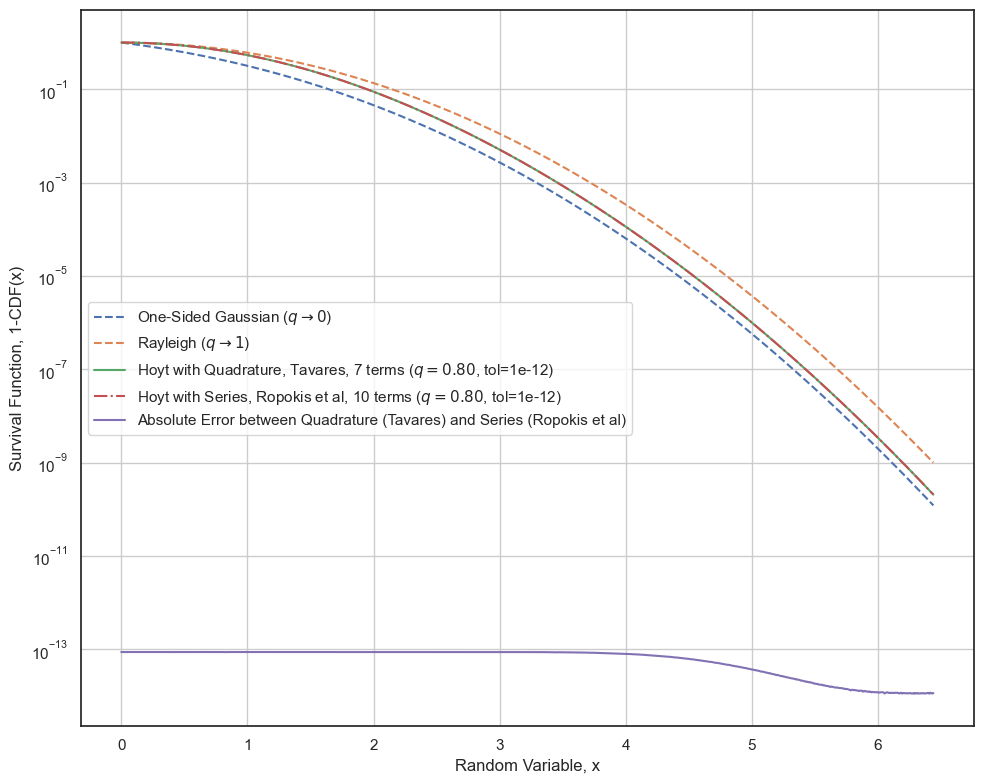

In [2]:
from hoyt_cumulative_density import *
from scipy.special import erf

s1 = 0.8
s2 = 1
threshold_rayleigh = np.sqrt(-2.0 * np.log(1e-9))
x = np.linspace(0, threshold_rayleigh, 1001)

tol = 1e-12
cdf_hoyt_quad, n_terms_quad = cumulative_density_hoyt(s1, s2, x, tol=tol)
cdf_hoyt_series, n_terms_series = cumulative_density_hoyt_series(s1, s2, x, tol=tol)

cdf_rayleigh = np.ones_like(x) - np.exp(-x**2/2)
cdf_onesided_gaussian =  (erf(x / np.sqrt(2)))

plt.figure()
plt.plot(x, 1-cdf_onesided_gaussian, '--', label="One-Sided Gaussian ($q\\rightarrow 0$)")
plt.plot(x, 1-cdf_rayleigh, '--', label="Rayleigh ($q\\rightarrow 1$)")
plt.plot(x, 1-cdf_hoyt_quad, label=f"Hoyt with Quadrature, Tavares, {n_terms_quad} terms ($q={s1/s2:.2f}$, tol={tol:.0e})")
plt.plot(x, 1-cdf_hoyt_series, '-.', label=f"Hoyt with Series, Ropokis et al, {n_terms_series} terms ($q={s1/s2:.2f}$, tol={tol:.0e})")
plt.plot(x, np.abs(cdf_hoyt_quad - cdf_hoyt_series), label="Absolute Error between Quadrature (Tavares) and Series (Ropokis et al)")
plt.xlabel("Random Variable, x")
plt.ylabel("Survival Function, 1-CDF(x)")
plt.yscale('log')
plt.legend()
plt.tight_layout()


## Computational Aspects of the Calculation of the Inverse CDF

The procedure for calculating the threshold for a given probability of exceedance / inverse CDF is iterative.
However, it is a stable process because a reasonable initial guess is the corresponding value for the Rayleigh inverse CDF, which admits a closed-form solution.

In this test, it is assumed that the larger of the two variances is always equal to 1, and the smaller is equal to $q$, i.e. $\sigma_x=q$ and $\sigma_y=1$.
Then the convergence behavior is characterized by the value of $q \in [0, 1]$, and $p = 10^{-k}, k=1,\ldots,9$.
Two properties are studied:
1. The relative change in threshold when compared to the Rayleigh inverse CDF.
2. The number of iterations required to converge upon an accurate result.

In [3]:
sigma_frac = np.linspace(0, 1, 101)
sigma_frac[0] = 1e-4
sigma_frac[-1] = 1-1e-4

prob = 10.0**(-np.arange(1, 10))

S, P = np.meshgrid(sigma_frac, prob)
s = np.ravel(S)
p = np.ravel(P)

t = np.zeros(len(s))
n = np.zeros(len(s))
ctr = 0
for (s_, p_) in zip(s, p):
    threshold, num_iterations = inverse_tail_probability_hoyt(s_, 1.0, p_, tol=1e-10)
    n[ctr] = num_iterations
    threshold_rayleigh = np.sqrt(-2.0 * np.log(p_))
    t[ctr] = threshold / threshold_rayleigh
    ctr += 1

threshold_ratio = np.reshape(t, S.shape)
num_iter = np.reshape(n, S.shape)

### Threshold Comparison Test

Let $\sigma_y = 1$ and $q$ vary over the interval $[0, 1]$.
Furthermore, let the probability of exceedance $p$ vary over the values $10^{-k}$, where $k=1,\ldots, 9$.

A threshold value for the given probability of exceedance can be calculated from the Rayleigh distribution, which corresponds to $q=1$:

$$ t_{Rayleigh} = {\rm CDF}^{-1}_{Rayleigh}(1 - p_{exceedance})$$

or,

$$t_{Rayleigh} = \sqrt{-2\ln(1 - p)}$$

Similarly, a threshold value can be calculated from the Hoyt distribution; this is denoted by $t_{Hoyt}(q)$, and is calculated from `inverse_tail_probability_hoyt(q, 1.0, p)`.
Notionally, it is given by the expression:

$$ t_{Hoyt} = {\rm CDF}^{-1}_{Hoyt}(1 - p_{exceedance}, q)$$

It can be shown that 

$$ 0 < \frac{t_{Hoyt}}{t_{Rayleigh}} \leq 1$$

The following figure shows the variation of this fraction over all reasonable values of probability of exceedance and over the entire range of the fraction $q$.
It should be noted that the threshold obtained from a Hoyt distribution can be at most 75% that of the threshold from the Rayleigh distribution.
This typically occurs for large values of exceedance probabilities (> 10^{-2}).

For exceedance probability values of $10^{-6}$ or lower, the Hoyt threshold is approximately 10% lower than the Rayleigh threshold.
Depending on the application, it may be useful to use the Rayleigh distribution for these values of exceedance probability given that there exists a closed-form, iteration-free solution for the inverse CDF of the Rayleigh distribution but not for the Hoyt distribution.

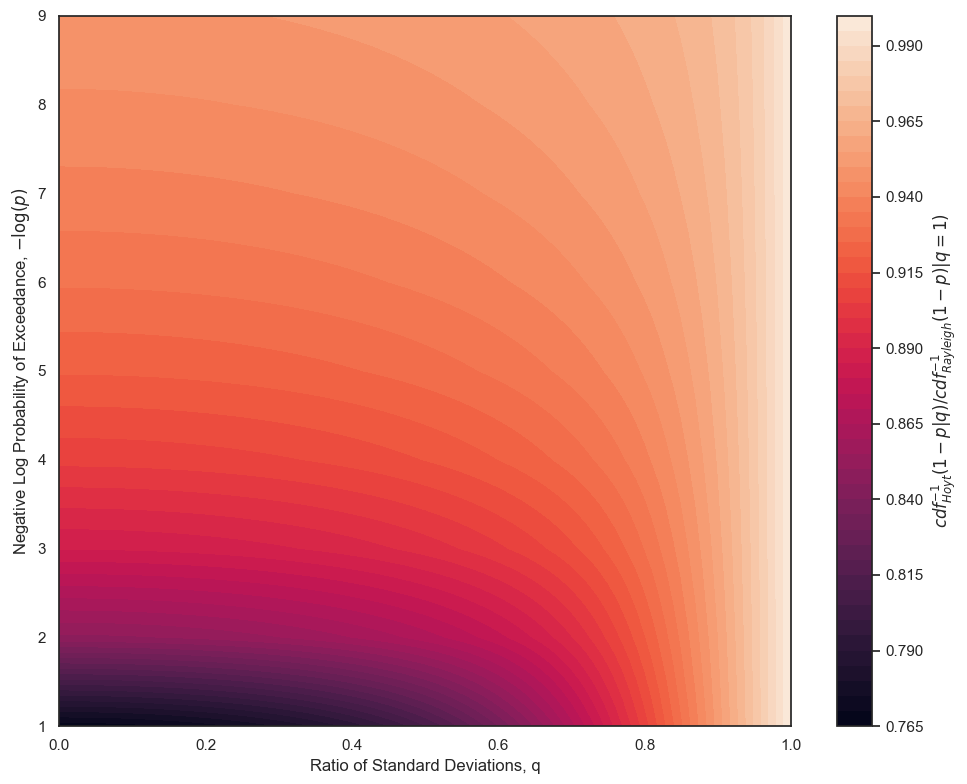

In [4]:
plt.figure()
plt.contourf(S, -np.log10(P), threshold_ratio, levels=50)
plt.xlabel("Ratio of Standard Deviations, q")
plt.ylabel("Negative Log Probability of Exceedance, $-\log(p)$")
plt.xlim([0, 1])
plt.colorbar(label="$cdf^{-1}_{Hoyt}(1-p|q) / cdf^{-1}_{Rayleigh}(1-p)|q=1)$")
plt.tight_layout()

### Numerical Complexity Test

The following image shows the number of iterations required to converge to an inverse CDF / threshold calculation.
The value of $q$ (ratio of standard deviations) is varied from 0 to 1 in the horizontal axis.
The threshold probability is varied from $10^{-1}$ to $10^{-9}$ along the vertical axis.

The colorbar shows that the results match intuition: the number of iterations required for convergence is larger the further we move towards the tail (e.g. $10^{-9}$), and for low values of $q$, where it is known that a larger number of quadrature points are required for calculating the CDF [1].

However, we never require more than 11 iterations for all practical values of the probability of exceedance, over the entire range of values for $q$.

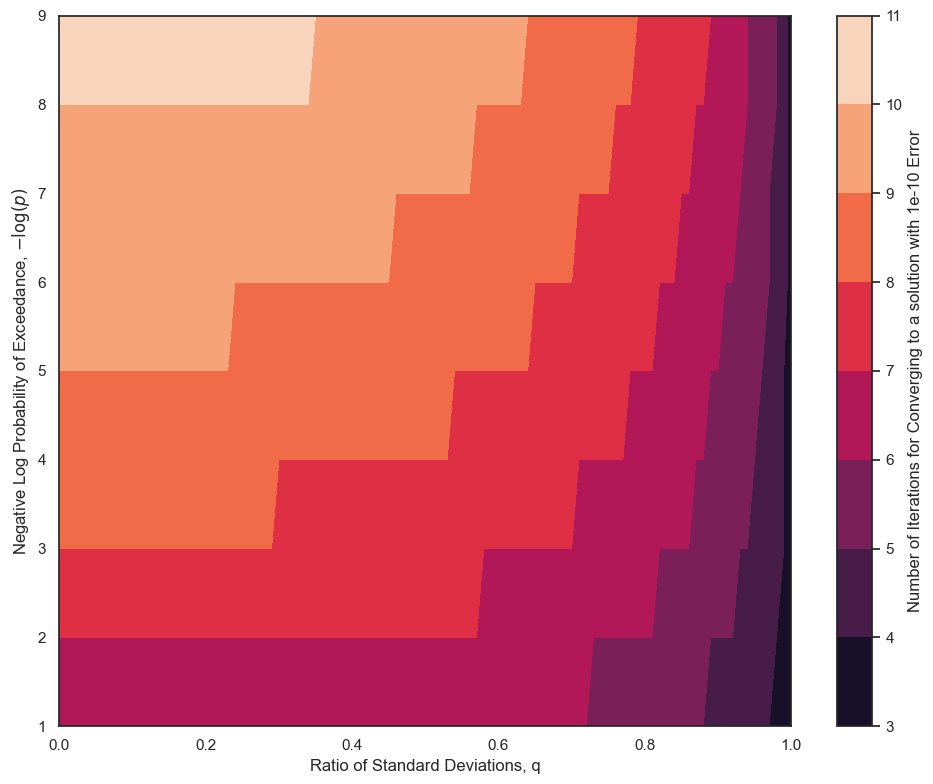

In [5]:
plt.figure()
plt.contourf(S, -np.log10(P), num_iter)
plt.xlabel("Ratio of Standard Deviations, q")
plt.ylabel("Negative Log Probability of Exceedance, $-\log(p)$")
plt.xlim([0, 1])
plt.colorbar(label="Number of Iterations for Converging to a solution with 1e-10 Error", ticks=np.arange(0, 12))
plt.tight_layout()

## Verification via Random Sampling

In this test, random numbers are generated along two axes where each axis is univariate normal:

$$x\sim{\mathcal N}(0, 1)$$
$$y\sim{\mathcal N}(0, 1)$$

Finally, a new random variable is constructed from the samples like so:

$$r = \sqrt{q^2 x^2 + y^2}$$

When $q$ is small, the statistics of $r$ are similar to that of $y$, i.e. a one-sided Gaussian distribution.
When $q\rightarrow 1$, the statistics of $r$ are close to a Rayleigh distribution.

In the following tests, for a given value of $q$ and given probability of exceedance $p$, a threshold is calculated using
1. one-sided Gaussian
2. Hoyt
3. Rayleigh

Then the number of samples that exceed each of these thresholds are counted and an observed probability of exceedance is calculated.
It is expected that the probability of exceedance using the Hoyt threshold will be closest to the expected value.

The foregoing test is performed for $q = 0.1$, $q=0.5$, and $q=0.9$.

In [6]:
n_samples = 250000000
x = np.random.normal(loc=0.0, scale=1, size=n_samples)
y = np.random.normal(loc=0.0, scale=1, size=n_samples)

In [7]:
from scipy.special import erfinv
for q in [0.1, 0.5, 0.9]:
    print(f"Ratio of Standard Deviations (q) = {q:.1f}")
    r = np.hypot(q * x, y)
    print("Theoretical p_exceedance ||      One-Sided Gaussian (q=0)     ||               *Hoyt*              ||          Rayleigh (q=1)          ")
    print("                         || Threshold | Observed p_exceedance || Threshold | Observed p_exceedance || Threshold | Observed p_exceedance")
    print("---------------------------------------------------------------------------------------------------------------------------------------")
    for p in prob:
        threshold_onesided_gaussian = erfinv(1 - p) * np.sqrt(2)
        p_onesided_gaussian = len(r[r > threshold_onesided_gaussian]) / len(r)
        
        threshold_hoyt, _ = inverse_tail_probability_hoyt(q, 1.0, p, tol=1e-12)
        p_hoyt = len(r[r > threshold_hoyt]) / len(r)
        
        threshold_rayleigh = np.sqrt(-np.log(p) * 2)
        p_rayleigh = len(r[r > threshold_rayleigh]) / len(r)

        print(f"{p:24.2e} ||"
              f"{threshold_onesided_gaussian:10.3f} | {p_onesided_gaussian:21.2e} ||"
              f"{threshold_hoyt:10.3f} | {p_hoyt:21.2e} ||"
              f"{threshold_rayleigh:10.3f} | {p_rayleigh:21.2e}")
    print("")


Ratio of Standard Deviations (q) = 0.1
Theoretical p_exceedance ||      One-Sided Gaussian (q=0)     ||               *Hoyt*              ||          Rayleigh (q=1)          
                         || Threshold | Observed p_exceedance || Threshold | Observed p_exceedance || Threshold | Observed p_exceedance
---------------------------------------------------------------------------------------------------------------------------------------
                1.00e-01 ||     1.645 |              1.01e-01 ||     1.648 |              1.00e-01 ||     2.146 |              3.20e-02
                1.00e-02 ||     2.576 |              1.01e-02 ||     2.578 |              9.99e-03 ||     3.035 |              2.42e-03
                1.00e-03 ||     3.291 |              1.00e-03 ||     3.292 |              9.98e-04 ||     3.717 |              2.03e-04
                1.00e-04 ||     3.891 |              1.01e-04 ||     3.892 |              1.00e-04 ||     4.292 |              1.80e-05
         